# Fine - Tuning: YOLO object detection on Pascal VOC Dataset

# Problem Statement and Model Selection

The objective of this project is to fine-tune a YOLO object detection model on the Pascal VOC dataset.

Based on the comparison of YOLO models in the sources below, YOLO11m variant was selected for fine-tuning (20.06M parameters ). Although no official benchmarks were found for **YOLO11 models on Pascal VOC dataset**, YOLO11 family has demonstrated strong and consistent performance across other datasets, with YOLO11m offering good balance between accuracy, speed, and model size.
Performance will be shown at the end of this notebook


In [1]:
%pip install -q ultralytics torch-ema albumentations tqdm pandas seaborn matplotlib torchmetrics

import os, random, json, gc
from pathlib import Path
import numpy as np
import torch
import cv2
import albumentations as A
from tqdm import tqdm
from ultralytics import YOLO
from torch.cuda.amp import GradScaler, autocast
from torch.optim import AdamW, SGD
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch_ema import ExponentialMovingAverage
from sklearn.model_selection import train_test_split
from ultralytics.utils.metrics import ap_per_class
import xml.etree.ElementTree as ET


# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Mounted at /content/drive


# Dataset: Pascal VOC 2007 & 2012

We train on the Pascal VOC 2007 and 2012 train + val sets. Combining both datasets gives us incresed sample size (19503 train, 2167 validation images) and scene variety, helping the model generalize better.

For testing only VOC 2007 test set is used.


In [2]:
def download_voc_dataset():
    # Download VOC2007
    !wget -q http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
    !wget -q http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
    !tar -xf VOCtrainval_06-Nov-2007.tar
    !tar -xf VOCtest_06-Nov-2007.tar

    # Download VOC2012
    !wget -q http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
    !tar -xf VOCtrainval_11-May-2012.tar

    # Create combined directory structure
    !mkdir -p VOCdevkit/VOCCombined
    !mkdir -p VOCdevkit/VOCCombined/Annotations
    !mkdir -p VOCdevkit/VOCCombined/JPEGImages
    !mkdir -p VOCdevkit/VOCCombined/ImageSets/Main

download_voc_dataset()

# Convert Pascal VOC to YOLO Format

`convert_voc_to_yolo()` helper function reads the original Pascal VOC XML annotations, computes each object’s bounding-box center coordinates and dimensions normalized by the image size, and writes them in the YOLO .txt format alongside the corresponding images.

It loops over both VOC2007 and VOC2012 splits, maps class names to indices, parses each entry, converts (xmin, ymin, xmax, ymax) to (x_center, y_center, width, height), and saves the results under `labels/` while copying the images into `images/`.

This function gives us a unified `VOCCombined` directory with YOLO-style labels and images ready for training.

In [3]:
VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
    'dog', 'horse', 'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor'
]
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(VOC_CLASSES)}

def convert_voc_to_yolo(voc_root, output_dir):
    """Convert VOC annotations to YOLO format"""
    os.makedirs(output_dir, exist_ok=True)

    # Process both VOC2007 and VOC2012
    for year in ['2007', '2012']:
        anno_dir = f'{voc_root}/VOC{year}/Annotations'
        img_dir = f'{voc_root}/VOC{year}/JPEGImages'

        for xml_file in tqdm(os.listdir(anno_dir), desc=f'Processing VOC{year}'):
            if not xml_file.endswith('.xml'):
                continue

            # Parse XML
            tree = ET.parse(os.path.join(anno_dir, xml_file))
            root = tree.getroot()

            # Get image size
            size = root.find('size')
            img_w = int(size.find('width').text)
            img_h = int(size.find('height').text)

            # Prepare YOLO format lines
            yolo_lines = []
            for obj in root.findall('object'):
                cls = obj.find('name').text
                bbox = obj.find('bndbox')
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)

                # Convert to YOLO format (center x, center y, width, height)
                x_center = ((xmin + xmax) / 2) / img_w
                y_center = ((ymin + ymax) / 2) / img_h
                width = (xmax - xmin) / img_w
                height = (ymax - ymin) / img_h

                yolo_lines.append(f"{CLASS_TO_IDX[cls]} {x_center} {y_center} {width} {height}")

            # Write YOLO annotation file
            base_name = os.path.splitext(xml_file)[0]
            with open(os.path.join(output_dir, f'{base_name}.txt'), 'w') as f:
                f.write('\n'.join(yolo_lines))

            # Copy image to combined directory
            img_src = os.path.join(img_dir, f'{base_name}.jpg')
            img_dst = os.path.join(output_dir.replace('labels', 'images'), f'{base_name}.jpg')
            if os.path.exists(img_src):
                os.system(f'cp "{img_src}" "{img_dst}"')

# Create directories
!mkdir -p VOCdevkit/VOCCombined/images
!mkdir -p VOCdevkit/VOCCombined/labels

# Convert annotations
convert_voc_to_yolo('VOCdevkit', 'VOCdevkit/VOCCombined/labels')

Processing VOC2012: 100%|██████████| 17125/17125 [01:06<00:00, 256.68it/s]


# Split Dataset into Train/Val/Test

`split_dataset()` helper function lists all JPEGs in `VOCCombined/images`, splits them 80/20 into train/test. After that splits 10% of the train set for validation, creates `train/val/test` folders under both `images/` and `labels/` folders. After that moves each image and its corresponding .txt label into the appropriate split folder.  


In [4]:
def split_dataset(test_size=0.2):
    # Get all image files
    image_files = [f for f in os.listdir('VOCdevkit/VOCCombined/images') if f.endswith('.jpg')]

    # Split into train and test (80/20)
    train_files, test_files = train_test_split(image_files, test_size=test_size, random_state=42)

    # Further split train into train and val (90/10 of train)
    train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)

    # Create directories
    os.makedirs('VOCdevkit/VOCCombined/images/train', exist_ok=True)
    os.makedirs('VOCdevkit/VOCCombined/images/val', exist_ok=True)
    os.makedirs('VOCdevkit/VOCCombined/images/test', exist_ok=True)
    os.makedirs('VOCdevkit/VOCCombined/labels/train', exist_ok=True)
    os.makedirs('VOCdevkit/VOCCombined/labels/val', exist_ok=True)
    os.makedirs('VOCdevkit/VOCCombined/labels/test', exist_ok=True)

    # Move files to appropriate directories
    for split, files in [('train', train_files), ('val', val_files), ('test', test_files)]:
        for file in tqdm(files, desc=f'Moving {split} files'):
            base_name = os.path.splitext(file)[0]

            # Move image
            src_img = os.path.join('VOCdevkit/VOCCombined/images', file)
            dst_img = os.path.join('VOCdevkit/VOCCombined/images', split, file)
            os.rename(src_img, dst_img)

            # Move label
            src_label = os.path.join('VOCdevkit/VOCCombined/labels', f'{base_name}.txt')
            dst_label = os.path.join('VOCdevkit/VOCCombined/labels', split, f'{base_name}.txt')
            if os.path.exists(src_label):
                os.rename(src_label, dst_label)

split_dataset()

Moving test files: 100%|██████████| 5418/5418 [00:00<00:00, 20233.36it/s]


# VOC → YOLO labels & VOC.yaml

In this part we set up the YOLO dataset configuration by writing a `voc.yaml` file.

The `path` key points to the `VOCCombined` root so that all file references (train/val/test) are relative and portable across machines.

Under each split (`images/train`, `images/val`, `images/test`), YOLO will look for matching label files in `labels/<split>`.

The `nc` field defines the number of object classes (20 for Pascal VOC)

Finally, `names` provides the exact class labels in order. This mapping ensures that when the model outputs class indices, we can correctly translate them back to class names during inference and evaluation.  


In [5]:
VOC_ROOT = '/content/VOCdevkit/VOCCombined'
VOC_CLASSES = [ 'aeroplane','bicycle','bird','boat','bottle',
                'bus','car','cat','chair','cow','diningtable',
                'dog','horse','motorbike','person','pottedplant',
                'sheep','sofa','train','tvmonitor' ]

# Assume labels in VOC_ROOT/labels and images in VOC_ROOT/images
# And you have already created train/val/test splits under those.
# Write the dataset YAML:
yaml = {
    'path': VOC_ROOT,
    'train':'images/train',
    'val':'images/val',
    'test':'images/test',
    'nc': len(VOC_CLASSES),
    'names': VOC_CLASSES
}
open('voc.yaml','w').write(json.dumps(yaml, indent=2))
print("✅ voc.yaml written")


✅ voc.yaml written


# Dataset & DataLoader

We implement custom `VOCDataset`, because the built-in `torchvision.datasets.VOCDetection` returns PIL images and raw XML annotations, which aren’t in the normalized YOLO tensor format or set up for our padding/augmentation pipeline.  

This custom `VOCDataset` reads each JPEG with its corresponding label, applies resizing and padding to img_size, if augment=True does some augmentation before normalizing. Bounding boxes stay as normalized (x_center, y_center, width, height). Each sample is returned as an image tensor (C, H, W) plus a target tensor (N, 5) where each row is [class, x, y, w, h].  

The `collate_fn` stacks image tensors into a batch and gathers variable-length target lists. This way different images can have different box counts. Then we create train/val datasets at IMG_SZ=640, wrap them in DataLoaders, and print sample counts to confirm.  


In [ ]:
class VOCDataset(Dataset):
    def __init__(self, img_dir, lbl_dir, img_size, augment=False):
        self.imgs = sorted(Path(img_dir).glob('*.jpg'))
        self.lbl_dir = Path(lbl_dir)
        self.sz = img_size
        self.augment = augment

        self.aug = A.Compose([
            A.LongestMaxSize(self.sz),
            A.PadIfNeeded(self.sz,self.sz),
            A.HorizontalFlip(p=0.5) if augment else A.NoOp(),
            A.ColorJitter(0.2,0.2,0.2,0.1,p=0.5) if augment else A.NoOp(),
            A.Normalize(),
        ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

    def __len__(self): return len(self.imgs)
    def __getitem__(self, i):
        p = self.imgs[i]
        img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
        lbl_path = self.lbl_dir/f"{p.stem}.txt"
        boxes,cls = [],[]
        if lbl_path.exists():
            for l in open(lbl_path):
                c,x,y,w,h = map(float,l.split())
                cls.append(int(c))
                boxes.append([x,y,w,h])
        res = self.aug(image=img, bboxes=boxes, class_labels=cls)
        img = torch.from_numpy(res['image'].transpose(2,0,1)).float()
        labels = torch.tensor(res['class_labels'], dtype=torch.int64)
        boxes  = torch.tensor(res['bboxes'], dtype=torch.float32)
        target = torch.cat([labels.unsqueeze(1), boxes],1) if len(boxes) else torch.zeros((0,5))
        return img, target

def collate_fn(batch):
    imgs, tgs = zip(*batch)
    imgs = torch.stack(imgs)
    tgs  = [t for t in tgs]
    return imgs, tgs

IMG_SZ = 640
BATCH = 64
train_ds = VOCDataset(VOC_ROOT+'/images/train', VOC_ROOT+'/labels/train', IMG_SZ, augment=True)
val_ds   = VOCDataset(VOC_ROOT+'/images/val',   VOC_ROOT+'/labels/val',   IMG_SZ, augment=False)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                      num_workers=4, pin_memory=True, collate_fn=collate_fn)
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False,
                      num_workers=4, pin_memory=True, collate_fn=collate_fn)
print(f" DataLoaders ready: {len(train_ds)} train, {len(val_ds)} val")


✅ DataLoaders ready: 19503 train, 2167 val


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configuration & Training

We collect all training configurations in CFG. Then we load the pretrained yolo11m.pt weights and apply these settings to model.args. Finally, we call model.train() with voc.yaml dataset and pass in the values from CFG.

When training finishes, the best weights are saved to `best.pt` and the top metrics are in `results.csv`.  


In [ ]:
CFG = {
    'MODEL_NAME':   'yolo11m',
    'EPOCHS':       30,
    'BATCH_SIZE':   BATCH,
    'LR':           1e-4,
    'OPTIMIZER':    'AdamW',
    'WEIGHT_DECAY': 1e-4,
    'AMP':          True,
    'FREEZE_BACKBONE': True,
    'FREEZE_LAYERS':  10,
}


model = YOLO(CFG['MODEL_NAME'])    # loads weights
model.args = ({
    'epochs':        CFG['EPOCHS'],
    'batch':         CFG['BATCH_SIZE'],
    'lr0':           CFG['LR'],
    'optimizer':     CFG['OPTIMIZER'].lower(),
    'weight_decay':  CFG['WEIGHT_DECAY'],
    'amp':           CFG['AMP'],
    'freeze':        list(range(CFG['FREEZE_LAYERS'])) if CFG['FREEZE_BACKBONE'] else None,
})
model.to(device)


100%|██████████| 38.8M/38.8M [00:00<00:00, 200MB/s]


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_

In [ ]:
results = model.train(
    data         = 'voc.yaml',
    epochs       = CFG['EPOCHS'],
    batch        = CFG['BATCH_SIZE'],
    lr0          = CFG['LR'],
    optimizer    = CFG['OPTIMIZER'].lower(),
    weight_decay = CFG['WEIGHT_DECAY'],
    amp          = CFG['AMP'],
    freeze       = 20
)


Ultralytics 8.3.141 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=voc.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=20, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train12, nbs=64, nms=False, opset=None, optimize=False, optimizer=adamw, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fa

train: Scanning /content/VOCdevkit/VOCCombined/labels/train.cache... 19503 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19503/19503 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 581.6±760.1 MB/s, size: 147.8 KB)


val: Scanning /content/VOCdevkit/VOCCombined/labels/val.cache... 2167 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2167/2167 [00:00<?, ?it/s]


Plotting labels to runs/detect/train12/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0001), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train12
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      7.43G     0.8507      1.271      1.172        259        640: 100%|██████████| 305/305 [08:10<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]


                   all       2167       5677       0.77      0.762       0.82      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      7.16G     0.8323     0.9113      1.155        189        640: 100%|██████████| 305/305 [08:33<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

                   all       2167       5677      0.795      0.774      0.833      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      7.31G     0.8338     0.8861      1.158        282        640: 100%|██████████| 305/305 [09:02<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:39<00:00,  2.30s/it]


                   all       2167       5677      0.769      0.793       0.83      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      7.46G     0.8337     0.8786       1.16        222        640: 100%|██████████| 305/305 [08:44<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

                   all       2167       5677      0.773      0.788      0.839      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         7G     0.8286       0.86      1.156        206        640: 100%|██████████| 305/305 [08:51<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]


                   all       2167       5677      0.795      0.773       0.84      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.87G     0.8169     0.8432      1.149        235        640: 100%|██████████| 305/305 [08:57<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]

                   all       2167       5677      0.778      0.794      0.848      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      7.09G     0.8137     0.8318      1.148        298        640: 100%|██████████| 305/305 [08:23<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:42<00:00,  2.47s/it]

                   all       2167       5677      0.768      0.804      0.848      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      7.09G     0.8061     0.8215       1.14        251        640: 100%|██████████| 305/305 [08:55<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]


                   all       2167       5677      0.793      0.805      0.852      0.678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      7.61G     0.8061     0.8119      1.139        271        640: 100%|██████████| 305/305 [08:38<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

                   all       2167       5677      0.807      0.779      0.856      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      7.03G     0.8032     0.8048      1.136        242        640: 100%|██████████| 305/305 [08:41<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:39<00:00,  2.35s/it]

                   all       2167       5677       0.79      0.793      0.853      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      7.03G     0.7927     0.7959      1.132        354        640:   6%|▌         | 19/305 [00:32<08:04,  1.69s/it]


KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

gc.collect()


179194

In [ ]:
results = model.train(
    data         = 'voc.yaml',
    epochs       = CFG['EPOCHS'],
    batch        = CFG['BATCH_SIZE'],
    lr0          = CFG['LR'],
    optimizer    = CFG['OPTIMIZER'].lower(),
    weight_decay = CFG['WEIGHT_DECAY'],
    amp          = CFG['AMP'],
    freeze       = 20,
    resume = True
)


Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=voc.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=20, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=best10.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train12, nbs=64, nms=False, opset=None, optimize=False, optimizer=adamw, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fal

train: Scanning /content/VOCdevkit/VOCCombined/labels/train.cache... 19503 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19503/19503 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 867.2±751.9 MB/s, size: 147.8 KB)


val: Scanning /content/VOCdevkit/VOCCombined/labels/val.cache... 2167 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2167/2167 [00:00<?, ?it/s]


Plotting labels to runs/detect/train12/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0001), 112 bias(decay=0.0)
Resuming training best10.pt from epoch 10 to 30 total epochs
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train12
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      13.4G     0.7987     0.8024      1.134        259        640: 100%|██████████| 305/305 [07:15<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

                   all       2167       5677       0.79      0.785      0.845      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      7.22G       0.79     0.7953      1.131        189        640: 100%|██████████| 305/305 [09:00<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

                   all       2167       5677       0.79      0.792      0.853      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      8.38G     0.7794     0.7831      1.125        282        640: 100%|██████████| 305/305 [09:03<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:34<00:00,  2.03s/it]

                   all       2167       5677      0.798      0.788      0.853       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      8.37G     0.7781      0.782      1.124        222        640: 100%|██████████| 305/305 [08:27<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

                   all       2167       5677      0.789      0.798      0.852      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      8.36G     0.7745     0.7701      1.121        206        640: 100%|██████████| 305/305 [08:11<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]

                   all       2167       5677      0.811      0.784      0.857      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      8.37G     0.7678     0.7605      1.117        235        640: 100%|██████████| 305/305 [08:12<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

                   all       2167       5677      0.802      0.791      0.856      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      8.37G     0.7651     0.7522      1.117        298        640: 100%|██████████| 305/305 [08:29<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

                   all       2167       5677      0.786      0.804      0.854      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      8.36G     0.7601     0.7464       1.11        251        640: 100%|██████████| 305/305 [08:32<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:39<00:00,  2.35s/it]

                   all       2167       5677      0.815      0.779      0.853      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      8.36G     0.7604     0.7405      1.111        271        640: 100%|██████████| 305/305 [07:59<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:36<00:00,  2.17s/it]

                   all       2167       5677      0.808      0.791      0.856      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      8.37G     0.7793     0.7565      1.119        242        640: 100%|██████████| 305/305 [08:24<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

                   all       2167       5677      0.816       0.78      0.858      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      8.37G     0.7751     0.7583       1.12        265        640: 100%|██████████| 305/305 [08:00<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

                   all       2167       5677      0.814      0.784      0.858      0.691


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      8.36G     0.7174     0.6208      1.063        114        640: 100%|██████████| 305/305 [08:16<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]

                   all       2167       5677      0.804      0.789      0.855       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      8.37G     0.7119     0.6097      1.059        102        640: 100%|██████████| 305/305 [08:33<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:39<00:00,  2.32s/it]

                   all       2167       5677      0.809      0.783      0.855      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      8.36G     0.7091     0.6048      1.057        100        640: 100%|██████████| 305/305 [08:44<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

                   all       2167       5677      0.803      0.794      0.855      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      8.36G     0.7047      0.595      1.056         99        640: 100%|██████████| 305/305 [08:41<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

                   all       2167       5677        0.8      0.797      0.856      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      8.37G        0.7     0.5868       1.05        146        640: 100%|██████████| 305/305 [08:32<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

                   all       2167       5677      0.819      0.787      0.855      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      8.36G     0.7114     0.6085      1.055        171        640:   4%|▎         | 11/305 [00:15<06:49,  1.39s/it]


KeyboardInterrupt: 

# Evaluation on Validation set

In [ ]:
model = YOLO ('best.pt')

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

results = model.val(
    data    = 'voc.yaml',
    batch   = 64,
    imgsz   = 640,
    workers = 4,
    save    = False
)

# box metrics
metrics = results.box


Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1701.3±572.1 MB/s, size: 79.4 KB)


val: Scanning /content/VOCdevkit/VOCCombined/labels/val.cache... 2167 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2167/2167 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]


                   all       2167       5677      0.798      0.798      0.856      0.694
             aeroplane         77        110      0.919      0.826      0.921      0.755
               bicycle        111        176      0.764      0.801      0.857      0.692
                  bird        121        169      0.844       0.87      0.912      0.754
                  boat         71        146      0.835      0.691      0.816      0.581
                bottle        104        210      0.732      0.733      0.788      0.585
                   bus         77        116      0.877      0.879      0.929      0.844
                   car        212        463      0.762      0.797      0.854      0.659
                   cat        131        149      0.932       0.94      0.969       0.89
                 chair        194        483      0.697      0.633      0.702      0.521
                   cow         44        110      0.875      0.836      0.909      0.693
           diningtabl

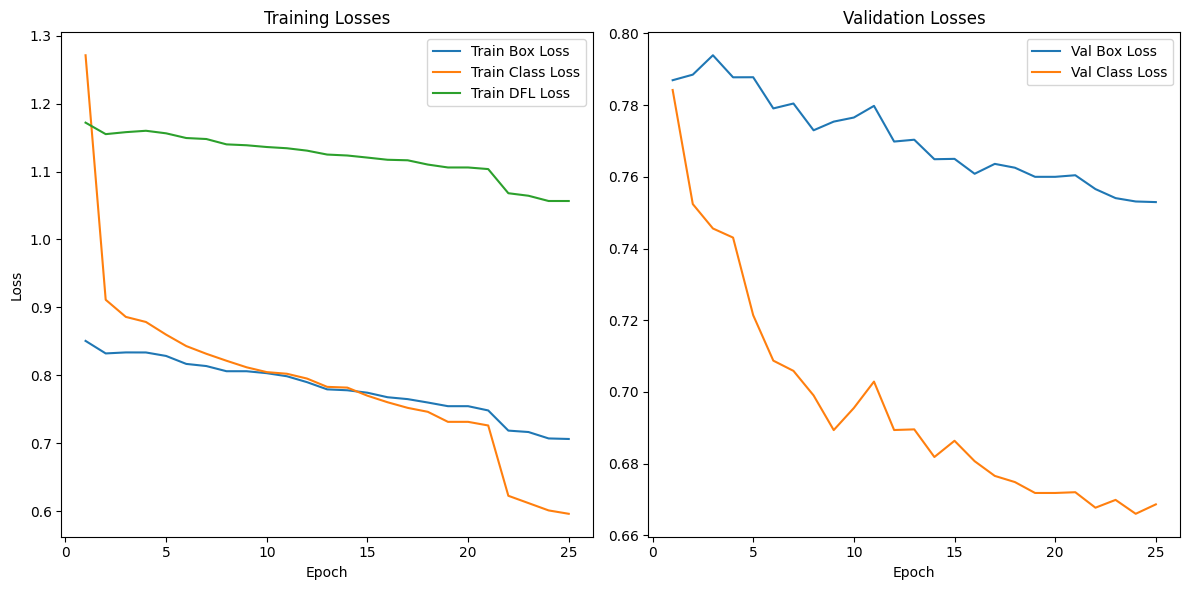

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training log
log = pd.read_csv('result.csv')

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(log['epoch'], log['train/box_loss'], label='Train Box Loss')
plt.plot(log['epoch'], log['train/cls_loss'], label='Train Class Loss')
plt.plot(log['epoch'], log['train/dfl_loss'], label='Train DFL Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(log['epoch'], log['val/box_loss'], label='Val Box Loss')
plt.plot(log['epoch'], log['val/cls_loss'], label='Val Class Loss')
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
print(f"mAP@[.5:.95]: {metrics.map:.4f}")
print(f"mAP@0.50: {metrics.map50:.4f}")
print(f"mAP@0.75: {metrics.map75:.4f}")

mAP@[.5:.95]: 0.6940
mAP@0.50: 0.8556
mAP@0.75: 0.7661


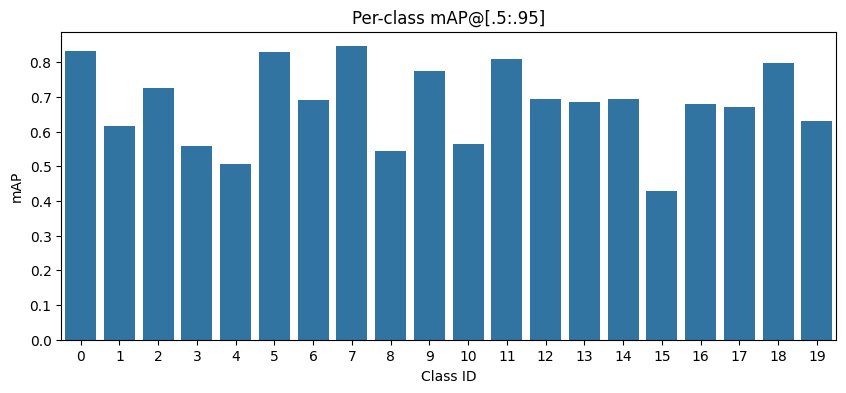

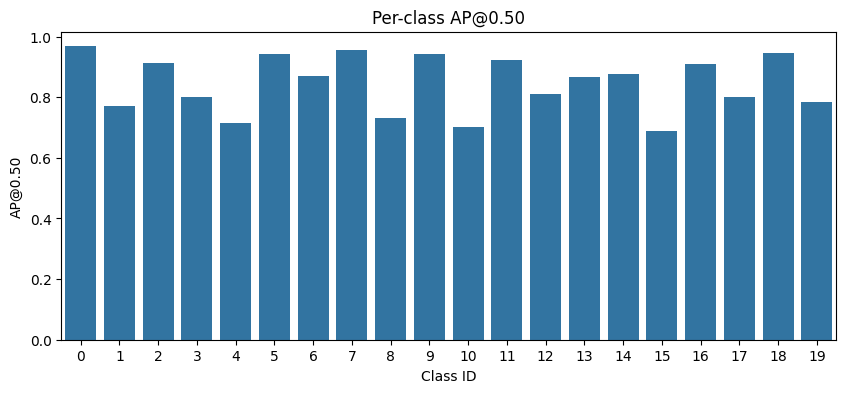

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame({
    'class_id':    list(range(metrics.nc)),
    'mAP_50_95':   metrics.maps,    # per-class mAP@[.5:.95]
    'AP@0.50':     metrics.ap50     # per-class AP@0.50
})
# Bar charts for per-class performance
plt.figure(figsize=(10,4))
sns.barplot(x='class_id', y='mAP_50_95', data=df)
plt.title('Per-class mAP@[.5:.95]'); plt.xlabel('Class ID'); plt.ylabel('mAP'); plt.show()
print("\n \n")
plt.figure(figsize=(10,4))
sns.barplot(x='class_id', y='AP@0.50', data=df)
plt.title('Per-class AP@0.50'); plt.xlabel('Class ID'); plt.ylabel('AP@0.50'); plt.show()


# Evaluation on test set

In [17]:
results = model.val(
    data='voc.yaml',
    split='test',
    batch=64,
    imgsz=640,
    workers=4,
    save=False
)

metrics = results.box
print(f"mAP@0.5: {metrics.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.map:.4f}")


Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1051.4±955.9 MB/s, size: 108.7 KB)


val: Scanning /content/VOCdevkit/VOCCombined/labels/test.cache... 5418 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5418/5418 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [02:09<00:00,  1.52s/it]


                   all       5418      14234      0.793      0.798      0.846      0.679
             aeroplane        251        348      0.941      0.934      0.968      0.831
               bicycle        207        316      0.739      0.731      0.772      0.616
                  bird        278        446      0.876      0.861      0.912      0.725
                  boat        188        356       0.82      0.689      0.802      0.558
                bottle        284        607      0.735       0.65      0.714      0.506
                   bus        185        264      0.902      0.864      0.942      0.829
                   car        556       1145       0.79      0.831      0.871      0.692
                   cat        362        409      0.896      0.924      0.955      0.846
                 chair        506       1213      0.669      0.697      0.731      0.545
                   cow        131        287      0.836      0.903      0.943      0.775
           diningtabl

# Benchmarks

Since no official benchmarks were found for **YOLO11 models on the Pascal VOC dataset**, I referred to available performance results from other datasets


Comparative Benchmarking of YOLO11m

| Dataset            | mAP50   | mAP50-95 | Precision | Recall | Inference Time (GPU) | Source                                                         |
|--------------------|---------|----------|-----------|--------|---------------------|----------------------------------------------------------------|
| **COCO**           | –       | 0.515    | –         | –      | –                   | [Ultralytics](https://yolov11.com)                             |
| **Traffic Signs**  | 0.893   | 0.795    | 0.898     | 0.826  | 2.4 ms              | [paper, page 15 ](https://arxiv.org/pdf/2411.00201)            |
| **Africa Wildlife**| 0.960   | 0.810    | 0.922     | 0.906  | 2.4 ms              | [paper, page 18 ](https://arxiv.org/pdf/2411.00201)            |
| **Ships & Vessels**| 0.530   | 0.325    | 0.588     | 0.541  | 2.4 ms              | [paper, page 21 ](https://arxiv.org/pdf/2411.00201)            |
| **USPS-Merge-38**  | 0.8919  | 0.7288   | 0.8972    | 0.8272 | 2.32 ms             | [paper, page 120](https://hal.science/hal-04838801v1/document) |



```
My Results on Pascal VOC 2007val + 2012val set:
mAP50: 0.8556
mAP75: 0.7661
mAP50-95:  0.6940

```

```
My Results on Pascal VOC 2007 test set:
mAP50: 0.8461
mAP50:95: 0.6788
```





# Export the model

To make the trained model deployable on various inference platforms, the best-performing checkpoint (best.pt) was saved and exported to multiple formats:

ONNX allows us to gain up to 3x CPU speedup.

TensorRT Engine is for optimized deployment on NVIDIA GPUs (up to 5x speedup), with support for dynamic input shapes and INT8 quantization for faster inference.



In [25]:
model.export(format="onnx", dynamic=True)

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 24, 8400) (59.5 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.53', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 9.0s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.53...
ONNX: export success ✅ 19.4s, saved as 'best.onnx' (76.6 MB)

Export complete (21.4s)
Results saved to /content
Predict:         yolo predict task=detect model=best.onnx imgsz=640  
Validate:        yolo val task=detect model=best.onnx imgsz=640 data=voc.yaml  
Visualize:       https://netron.app


'best.onnx'

In [28]:
model.export(format="engine", dynamic=True)

WARNING ⚠️ TensorRT requires GPU export, automatically assigning device=0
Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

PyTorch: starting from 'best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 24, 8400) (59.5 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.53...
ONNX: export success ✅ 8.6s, saved as 'best.onnx' (76.6 MB)

TensorRT: starting export with TensorRT 10.11.0.33...
TensorRT: input "images" with shape(-1, 3, -1, -1) DataType.FLOAT
TensorRT: output "output0" with shape(-1, 24, -1) DataType.FLOAT
WARNING ⚠️ TensorRT: 'dynamic=True' model requires max batch size, i.e. 'batch=16'
TensorRT: building FP32 engine as best.engine
TensorRT: export success ✅ 110.9s, saved as 'best.engine' (86.9 MB)

Export complete (111.1s)
Results saved to /content
Predict:         yolo predict task=detect model=best.engine imgsz=640  
Validate:        yolo val task=detect model=best.engine imgsz=640 da

'best.engine'

In [29]:
model.export(format="engine", int8 = True, dynamic=True)

WARNING ⚠️ TensorRT requires GPU export, automatically assigning device=0
Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
WARNING ⚠️ INT8 export requires a missing 'data' arg for calibration. Using default 'data=coco8.yaml'.

PyTorch: starting from 'best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 24, 8400) (59.5 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.53...
ONNX: export success ✅ 8.9s, saved as 'best.onnx' (76.6 MB)

TensorRT: starting export with TensorRT 10.11.0.33...
TensorRT: collecting INT8 calibration images from 'data=coco8.yaml'
Fast image access ✅ (ping: 0.0±0.0 ms, read: 823.5±331.9 MB/s, size: 54.0 KB)


Scanning /content/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]

WARNING ⚠️ TensorRT: >300 images recommended for INT8 calibration, found 4 images.
TensorRT: input "images" with shape(-1, 3, -1, -1) DataType.FLOAT
TensorRT: output "output0" with shape(-1, 24, -1) DataType.FLOAT
WARNING ⚠️ TensorRT: 'dynamic=True' model requires max batch size, i.e. 'batch=16'
TensorRT: building INT8 engine as best.engine


TensorRT: export success ✅ 196.0s, saved as 'best.engine' (24.8 MB)

Export complete (196.2s)
Results saved to /content
Predict:         yolo predict task=detect model=best.engine imgsz=640 int8 
Validate:        yolo val task=detect model=best.engine imgsz=640 data=voc.yaml int8 
Visualize:       https://netron.app


'best.engine'